In [1]:
import os
import sys
import numpy as np
import polars as pl

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(notebook_dir)



project_path = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding"
model = "FOXA1"
sample = "22Rv1"
jaspar_file = f"/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/motifs/{model}.jaspar"  # Update this path
ground_truth_file = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/transcription_factors/FOXA1/merged/22RV1_FOXA1_merged.bed"

df = pl.read_parquet("/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/processed_results/FOXA1-NoFlip_22Rv1_processed.parquet", 
                    columns=["chr_name", "start", "end", "cell_line", "targets", "predicted", "weights", "probabilities", "attributions"],
                    parallel="columns",                     # Enable parallel reading
                    use_statistics=True,                    # Use parquet statistics
                    memory_map=True).lazy()                         # Use memory mapping
df = df.rename({"chr_name": "chr"})
df


In [2]:
import os
import tempfile
import polars as pl
from src.utils.generate_training_peaks import run_bedtools_command

def intersect_bed_files(main_df: pl.LazyFrame, intersect_df: pl.DataFrame, region_type: str = None) -> pl.LazyFrame:
    """
    Intersect two BED files using bedtools and return the original DataFrame with overlap flags.
    Args:
    main_df: Primary Polars DataFrame with BED data
    intersect_df: Secondary Polars DataFrame to intersect with
    region_type: Optional region type label to add to results
    Returns:
    Original DataFrame with additional column indicating overlaps
    """
    # Get column names from schema
    main_cols = main_df.schema.keys()
    
    with tempfile.NamedTemporaryFile(delete=False, mode='w') as main_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as intersect_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as result_file:
        main_path = main_file.name
        intersect_path = intersect_file.name
        result_path = result_file.name
        
        # Write DataFrames to temporary files - collect LazyFrame first
        main_df.collect().write_csv(main_path, separator="\t", include_header=False)
        intersect_df.write_csv(intersect_path, separator="\t", include_header=False)
        
        # Run bedtools intersect with -c flag to count overlaps
        command = f"bedtools intersect -a {main_path} -b {intersect_path} -c > {result_path}"
        run_bedtools_command(command)
        
        # Read results back into Polars DataFrame
        result_df = pl.read_csv(
            result_path,
            separator="\t",
            has_header=False,
            new_columns=[*main_cols, "overlap_count"]
        ).lazy()
        
        # Clean up temporary files
        os.remove(main_path)
        os.remove(intersect_path)
        os.remove(result_path)
        
        # Add boolean overlap column
        return result_df.with_columns(
            pl.col("overlap_count").gt(0).alias("overlaps_ground_truth")
        ).drop("overlap_count")

HIGH_COUNT_QUANTILE = 0.75
MAX_COUNT_THRESHOLD = 30
MID_COUNT_THRESHOLD = 10

def threshold_peaks(df):
    """
    Filter peaks based on count thresholds.
    Works with both DataFrame and LazyFrame.
    """
    # Handle scalar operations safely
    def get_scalar(expr):
        if isinstance(df, pl.LazyFrame):
            return expr.collect().item()
        return expr.item()
    
    max_count = get_scalar(df.select(pl.col("count").max()))
    
    if max_count <= 2:
        return df
    elif max_count > MAX_COUNT_THRESHOLD:
        threshold = get_scalar(df.select(pl.col("count").quantile(HIGH_COUNT_QUANTILE)))
        return df.filter(pl.col("count") > threshold)
    elif max_count > MID_COUNT_THRESHOLD:
        threshold = get_scalar(df.select(pl.col("count").median()))
        return df.filter(pl.col("count") > threshold)
    
    return df

# Usage example:
df_ground_truth = pl.read_csv(ground_truth_file,
                             separator="\t",
                             has_header=False,
                             new_columns=["chr", "start", "end", "count"],
                             columns=[0,1,2,3])

df_ground_truth_filtered = threshold_peaks(df_ground_truth)

# Use select() instead of subscripting
intersected_df = intersect_bed_files(df.select(["chr", "start", "end"]), df_ground_truth_filtered)

# add overlaps ground truth to df from intersected_df
ground_truth_df = df.join(intersected_df, on=["chr", "start", "end"], how="left")

# add overlaps_ground_truth to df under targets, 1 if overlaps_ground_truth is true, 0 otherwise
ground_truth_df = ground_truth_df.with_columns(
    pl.when(pl.col("overlaps_ground_truth")).then(1).otherwise(0).alias("targets")
)

/tmp/ipykernel_231029/1164732145.py:17: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  main_cols = main_df.schema.keys()


In [3]:
# Step 1: Keep the filtering lazy until collection
# Corrected: Added parentheses around individual conditions
df_positive_correct = ground_truth_df.filter(
    (pl.col("targets") == 1) & (pl.col("predicted") == 1)
).collect()

df_negative_correct_all = ground_truth_df.filter(
    (pl.col("targets") == 0) & (pl.col("predicted") == 0)
).collect()

# Step 2: Get the count of positive samples
pos_count = len(df_positive_correct)

# Step 3: Sample from the materialized negative DataFrame
df_negative = df_negative_correct_all.sample(
    n=min(pos_count, len(df_negative_correct_all)), seed=42
)

# Step 4: Concatenate the two DataFrames
df_balanced = pl.concat([df_positive_correct, df_negative])

df_balanced

chr,start,end,cell_line,targets,predicted,weights,probabilities,attributions,overlaps_ground_truth
str,i64,i64,str,i32,f64,f64,f64,list[list[f64]],bool
"""chr3""",131331117,131332340,"""22Rv1""",1,1.0,-1.0,0.999869,"[[0.0, 0.0, … 0.0127], [0.0, 0.036142, … 0.013699], … [0.0, 0.0, … 0.024706]]",true
"""chr3""",194870593,194872665,"""22Rv1""",1,1.0,-1.0,0.999569,"[[0.0, 0.0, … 0.061992], [0.079921, 0.0, … 0.064706], … [0.0, 0.0, … -0.005459]]",true
"""chr9""",127954906,127956174,"""22Rv1""",1,1.0,-1.0,0.999902,"[[0.0, 0.0, … -0.025018], [-0.011296, 0.00434, … -0.040145], … [0.0, 0.0, … -0.011693]]",true
"""chr2""",224971207,224971562,"""22Rv1""",1,1.0,-1.0,0.996018,"[[0.0, 0.0, … 0.001533], [0.0, 0.0, … 0.004405], … [0.0, 0.0, … 0.005174]]",true
"""chr1""",243849057,243851465,"""22Rv1""",1,1.0,-1.0,0.997744,"[[0.0, 0.0, … 0.032383], [0.0, 0.0, … 0.032349], … [0.0, 0.0, … -0.072369]]",true
…,…,…,…,…,…,…,…,…,…
"""chr7""",18086102,18087777,"""22Rv1""",0,0.0,-1.0,0.481723,"[[0.0, 0.0, … 0.017096], [0.09583, 0.0, … 0.017224], … [0.0, 0.0, … 0.012099]]",false
"""chr1""",221182842,221184746,"""22Rv1""",0,0.0,-1.0,0.000743,"[[0.0, 0.0, … -0.000215], [-0.251215, 0.0, … -0.006066], … [0.0, 0.0, … 0.000619]]",false
"""chr11""",35373172,35374193,"""22Rv1""",0,0.0,-1.0,0.002642,"[[0.0, 0.0, … -0.006521], [-0.028462, 0.047885, … -0.007637], … [0.0, 0.0, … -0.002438]]",false


In [4]:
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, List, Dict
import pysam

def process_pileups(pileup_dir: Path, chr_name: str, start: int, end: int) -> pl.DataFrame:
    """Process pileup files for a given genomic region with 4096bp context."""
    context_length = 4_096
    interval_length = end - start
    extra_seq = context_length - interval_length
    extra_left_seq = extra_seq // 2
    extra_right_seq = extra_seq - extra_left_seq
    start -= extra_left_seq
    end += extra_right_seq
    
    # Get the pileup file for the given chromosome
    pileup_file = pileup_dir / f"{chr_name}.pileup.gz"
    assert pileup_file.exists(), f"pileup file for {pileup_file} does not exist"
    
    tabixfile = pysam.TabixFile(str(pileup_file))
    records = []
    for rec in tabixfile.fetch(chr_name, start, end):
        records.append(rec.split("\t"))
    
    # Convert records to a DataFrame using Polars
    df = pl.DataFrame({
        "chr_name": [rec[0] for rec in records],
        "position": [int(rec[1]) for rec in records],
        "nucleotide": [rec[2] for rec in records],
        "count": [float(rec[3]) for rec in records],
    })
    
    return df


def create_position_to_count_mapping(pileup_df: pl.DataFrame) -> Dict[int, float]:
    """Create a mapping from genomic position to ATAC count."""
    return dict(zip(pileup_df['position'].to_list(), pileup_df['count'].to_list()))


def create_atac_pileup_array(position_count_map: Dict[int, float], 
                            start_pos: int, 
                            length: int = 4096) -> np.ndarray:
    """Create ATAC pileup array for a genomic region."""
    atac_array = np.zeros(length)
    
    for i in range(length):
        pos = start_pos + i
        if pos in position_count_map:
            atac_array[i] = position_count_map[pos]
    
    return atac_array


def reshape_attributions_fast(df: pl.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fast reshape attribution data using vectorized operations.
    
    Returns:
        attrs_list: Attribution scores for ACGT (shape: n_samples, 4, 4096)
        atac_attribution_list: ATAC attribution scores (shape: n_samples, 4096)
    """
    print("Reshaping attribution data...")
    # Convert to numpy array more efficiently
    attributions = np.array(df['attributions'].to_list())
    
    # Vectorized reshape - much faster than loops
    reshaped = attributions.reshape(-1, 4096, 5)
    
    # Split into ACGT and ATAC components
    attrs_list = reshaped[..., :4].transpose(0, 2, 1)  # Shape: (n_samples, 4, 4096)
    atac_attribution_list = reshaped[..., 4]  # Shape: (n_samples, 4096)
            
    return attrs_list, atac_attribution_list


def process_pileups_batch(pileup_dir: Path, regions_df: pl.DataFrame) -> Dict[int, np.ndarray]:
    """Process multiple pileup regions for a single cell line efficiently."""
    context_length = 4_096
    atac_arrays = {}
    
    # Get unique chromosomes to minimize file operations
    chromosomes = regions_df['chr'].unique().to_list()
    chr_tabix_files = {}
    
    # Open all needed tabix files once
    print(f"Opening tabix files for {len(chromosomes)} chromosomes...")
    for chr_name in tqdm(chromosomes, desc="Loading chromosome files", leave=False):
        pileup_file = pileup_dir / f"{chr_name}.pileup.gz"
        if pileup_file.exists():
            chr_tabix_files[chr_name] = pysam.TabixFile(str(pileup_file))
    
    # Process each region
    region_iterator = regions_df.iter_rows(named=True)
    total_regions = len(regions_df)
    
    for row in tqdm(region_iterator, total=total_regions, desc="Processing regions", leave=False):
        idx, chr_name, start, end = row['idx'], row['chr'], row['start'], row['end']
        
        # Calculate adjusted coordinates
        interval_length = end - start
        extra_seq = context_length - interval_length
        extra_left_seq = extra_seq // 2
        extra_right_seq = extra_seq - extra_left_seq
        adj_start = start - extra_left_seq
        adj_end = end + extra_right_seq
        
        # Initialize array
        atac_array = np.zeros(context_length)
        
        # Get data if tabix file exists
        if chr_name in chr_tabix_files:
            tabixfile = chr_tabix_files[chr_name]
            
            # Collect all positions and counts at once
            positions = []
            counts = []
            
            try:
                for rec in tabixfile.fetch(chr_name, adj_start, adj_end):
                    fields = rec.split("\t")
                    positions.append(int(fields[1]))
                    counts.append(float(fields[3]))
                
                # Vectorized assignment
                if positions:
                    positions = np.array(positions)
                    counts = np.array(counts)
                    
                    # Calculate array indices
                    array_indices = positions - adj_start
                    
                    # Filter valid indices
                    valid_mask = (array_indices >= 0) & (array_indices < context_length)
                    valid_indices = array_indices[valid_mask]
                    valid_counts = counts[valid_mask]
                    
                    # Assign values
                    atac_array[valid_indices] = valid_counts
                    
            except Exception as e:
                print(f"Warning: Could not fetch data for {chr_name}:{adj_start}-{adj_end}: {e}")
        
        atac_arrays[idx] = atac_array
    
    # Close tabix files
    print("Closing tabix files...")
    for tabixfile in chr_tabix_files.values():
        tabixfile.close()
    
    return atac_arrays


def process_region_data_fast(df: pl.DataFrame, base_pileup_dir: Path = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fast process both attribution and pileup data using Polars optimizations.
    
    Args:
        df: DataFrame containing attribution data and region info (chr, start, end, cell_line columns)
        base_pileup_dir: Base directory path for pileup files (optional, uses default if None)
    
    Returns:
        attrs_list: Attribution scores for ACGT
        atac_attribution_list: ATAC attribution scores
        atac_pileup_list: Raw ATAC pileup counts
    """
    if base_pileup_dir is None:
        base_pileup_dir = Path("/data1/projects/human_cistrome/aligned_chip_data/merged_cell_lines/")
    
    print(f"Processing {len(df)} regions across cell lines...")
    
    # Get attribution data (fast vectorized version)
    attrs_list, atac_attribution_list = reshape_attributions_fast(df)
    
    # Add row index for tracking
    df_with_idx = df.with_row_index("idx")
    
    # Group by cell line for batch processing
    atac_pileup_arrays = [None] * len(df)
    cell_line_groups = list(df_with_idx.group_by("cell_line"))
    
    print(f"Processing {len(cell_line_groups)} cell lines...")
    
    for cell_line, group_df in tqdm(cell_line_groups, desc="Processing cell lines"):
        cell_line_name = cell_line[0]
        
        # Construct cell-line specific pileup directory
        pileup_dir = base_pileup_dir / cell_line_name / "pileup_mod"
        
        if not pileup_dir.exists():
            print(f"Warning: Pileup directory does not exist: {pileup_dir}")
            # Fill with zeros for this cell line
            for row in group_df.iter_rows(named=True):
                atac_pileup_arrays[row['idx']] = np.zeros(4096)
            continue
        
        print(f"Processing {len(group_df)} regions for cell line: {cell_line_name}")
        
        # Process all regions for this cell line at once
        atac_arrays_dict = process_pileups_batch(pileup_dir, group_df)
        
        # Assign to the correct positions in the final array
        for idx, atac_array in atac_arrays_dict.items():
            atac_pileup_arrays[idx] = atac_array
    
    print("Converting to final numpy arrays...")
    # Convert to numpy array
    atac_pileup_list = np.array(atac_pileup_arrays)
    
    print("Processing complete!")
    return attrs_list, atac_attribution_list, atac_pileup_list

attrs_list, atac_attribution_list, atac_pileup_list = process_region_data_fast(df_positive_correct)

Processing 19786 regions across cell lines...
Reshaping attribution data...
Processing 1 cell lines...


Processing cell lines:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 19786 regions for cell line: 22Rv1
Opening tabix files for 24 chromosomes...


Processing cell lines: 100%|██████████| 1/1 [14:59<00:00, 899.07s/it]


Closing tabix files...
Converting to final numpy arrays...
Processing complete!


In [9]:
# Import additional required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo
from tangermeme.seqlet import recursive_seqlets


def get_seqlets(attrs_list, use_absolute_values=False):
    """Extract seqlets from attribution data."""
    attrs_array = np.stack(attrs_list, axis=0)

    # Sum attributions across one-hot encoded dimension
    summed_attrs = attrs_array.sum(axis=1)

    # Optionally use absolute values
    if use_absolute_values:
        summed_attrs = np.abs(summed_attrs)

    seqlets = recursive_seqlets(summed_attrs)

    nt_idx = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

    # Add sequences to seqlets df
    sequences = []
    for i in range(len(seqlets)):
        sample = seqlets.iloc[i]
        start = int(sample['start'])
        end = int(sample['end'])
        sample_idx = int(sample['example_idx'])

        sample_attrs = attrs_array[sample_idx, :, start:end].T.squeeze()
        hits = np.argmax(sample_attrs, axis=1)
        seq = ''.join([nt_idx[i] for i in hits])
        sequences.append(seq)
    
    seqlets['sequence'] = sequences
    return seqlets


def plot_seqlet_with_atac(seqlets, attrs_list, atac_attribution_list, atac_pileup_list, 
                         sample_rank=0, context_size=20, colormap='RdBu_r'):
    """
    Create a two-panel plot:
    - Top: DNA base attributions (logo plot)  
    - Bottom: ATAC pileup with attribution heatmap background
    
    Parameters:
    -----------
    seqlets : pandas.DataFrame
        DataFrame containing sequence information
    attrs_list : list or np.ndarray
        List/array of DNA attribution arrays
    atac_attribution_list : list or np.ndarray
        List/array of ATAC attribution data arrays
    atac_pileup_list : list or np.ndarray
        List/array of ATAC-seq pileup data arrays
    sample_rank : int, default=0
        Index of the sample to plot
    context_size : int, default=20
        Size of context around the seqlet to include in the plot
    colormap : str, default='RdBu_r'
        Matplotlib colormap for the attribution heatmap
    """
    # Extract sample information
    sample = seqlets.iloc[[sample_rank]]
    slice_idx = int(sample['example_idx'].tolist()[0])
    sequence = sample['sequence'].tolist()[0]
    start = int(sample['start'].tolist()[0])
    end = int(sample['end'].tolist()[0])
    p_value = sample['p-value'].tolist()[0]

    # Calculate the seqlet center and window boundaries
    seqlet_center = (start + end) // 2
    seqlet_length = end - start
    
    # Calculate window with context - use the seqlet length + context on both sides
    total_window_size = seqlet_length + (2 * context_size)
    window_start = seqlet_center - (total_window_size // 2)
    window_end = seqlet_center + (total_window_size // 2)
    
    # Ensure window is within data bounds (all arrays are 4096 long)
    window_start = max(0, window_start)
    window_end = min(4096, window_end)
    
    # Adjust if window got truncated to maintain consistent size
    if window_end - window_start < total_window_size:
        if window_start == 0:
            window_end = min(4096, window_start + total_window_size)
        elif window_end == 4096:
            window_start = max(0, window_end - total_window_size)
    
    print(f"Seqlet: {start}-{end} (center: {seqlet_center})")
    print(f"Window: {window_start}-{window_end} (size: {window_end - window_start})")
    print(f"P-Value: {p_value}")
    
    # Create identical coordinate arrays for both plots
    plot_coords = np.arange(window_start, window_end)
    
    # Get and window all data using IDENTICAL indices
    X_attr = attrs_list[slice_idx].astype(np.float64)
    atac_attr = atac_attribution_list[slice_idx].astype(np.float64)
    atac_pileup = atac_pileup_list[slice_idx].astype(np.float64)
    
    # Apply identical windowing to all arrays
    X_attr_windowed = X_attr[:, window_start:window_end]
    atac_attr_windowed = atac_attr[window_start:window_end]
    atac_pileup_windowed = atac_pileup[window_start:window_end]
    
    print(f"Windowed shapes: DNA={X_attr_windowed.shape}, ATAC_attr={atac_attr_windowed.shape}, ATAC_pileup={atac_pileup_windowed.shape}")

    # Create figure with custom layout for colorbar positioning
    fig = plt.figure(figsize=(18, 10), dpi=300)
    
    # Create subplot layout with space for colorbar on right
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], 
                         hspace=0.3, wspace=0.02)
    
    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])  # Top panel for DNA
    ax2 = fig.add_subplot(gs[1, 0])  # Bottom panel for ATAC
    cax = fig.add_subplot(gs[1, 1])  # Colorbar

    # Top panel: DNA Attribution logo plot
    plot_logo(X_attr_windowed, ax=ax1)
    
    # Set x-ticks to show genomic coordinates that match the ATAC plot exactly
    n_ticks = 8
    tick_positions = np.linspace(0, len(plot_coords)-1, n_ticks)
    tick_labels = np.linspace(plot_coords[0], plot_coords[-1], n_ticks).astype(int)
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels)
    ax1.set_xlabel("Genomic Coordinate")
    ax1.set_ylabel("DNA Attributions")
    ax1.set_title(f"DNA Base Attributions | Sample: {slice_idx} | {sequence}")

    # Bottom panel: ATAC pileup with attribution heatmap background
    # Create heatmap background for ATAC attribution
    heatmap_height = 25
    attr_heatmap = np.tile(atac_attr_windowed, (heatmap_height, 1))
    
    # Determine y-axis limits based on pileup data
    max_pileup = np.max(atac_pileup_windowed) if len(atac_pileup_windowed) > 0 else 1
    y_max = max_pileup * 1.1
    
    # Create the heatmap background using the SAME coordinate system as DNA plot
    im = ax2.imshow(attr_heatmap, 
                    cmap=colormap,
                    aspect='auto',
                    extent=[plot_coords[0], plot_coords[-1], 0, y_max],
                    alpha=0.7,
                    interpolation='bilinear')
    
    # Plot ATAC pileup as line on top using the SAME coordinates as DNA plot
    ax2.plot(plot_coords, atac_pileup_windowed, color='black', linewidth=2.5, 
             label='ATAC-seq Pileup', alpha=0.9)
    
    # Set x-limits to match DNA plot exactly
    ax2.set_xlim(plot_coords[0], plot_coords[-1])
    
    # Add colorbar to the dedicated axis on the far right
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('ATAC Attribution', rotation=270, labelpad=15, fontsize=11)
    
    # Format bottom panel
    ax2.set_xlabel("Genomic Coordinate")
    ax2.set_ylabel("ATAC-seq Signal")
    ax2.set_title(f"ATAC Pileup with Attribution Heatmap | Sample: {slice_idx}")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.show()

In [6]:
seqlets = get_seqlets(attrs_list)
filtered_seqlets = seqlets[seqlets["sequence"] == "AAAAA"]
filtered_seqlets

,example_idx,start,end,attribution,p-value,sequence
340,10602,1667,1672,-6.327283,0.000044,AAAAA
368,8889,2029,2034,-6.291553,0.000047,AAAAA
750,13184,2302,2307,-5.367731,0.000091,AAAAA
794,1225,1875,1880,15.642306,0.000095,AAAAA
1877,2705,1973,1978,-5.815860,0.000210,AAAAA
...,...,...,...,...,...,...
109567,13736,994,999,0.921210,0.009532,AAAAA
109573,8415,2250,2255,1.021970,0.009532,AAAAA
109666,7530,2065,2070,-1.187723,0.009601,AAAAA
109880,11002,1955,1960,-1.370802,0.009673,AAAAA


Seqlet: 1416-1425 (center: 1420)
Window: 416-2424 (size: 2008)
P-Value: 6.976530219249266e-05
Windowed shapes: DNA=(4, 2008), ATAC_attr=(2008,), ATAC_pileup=(2008,)


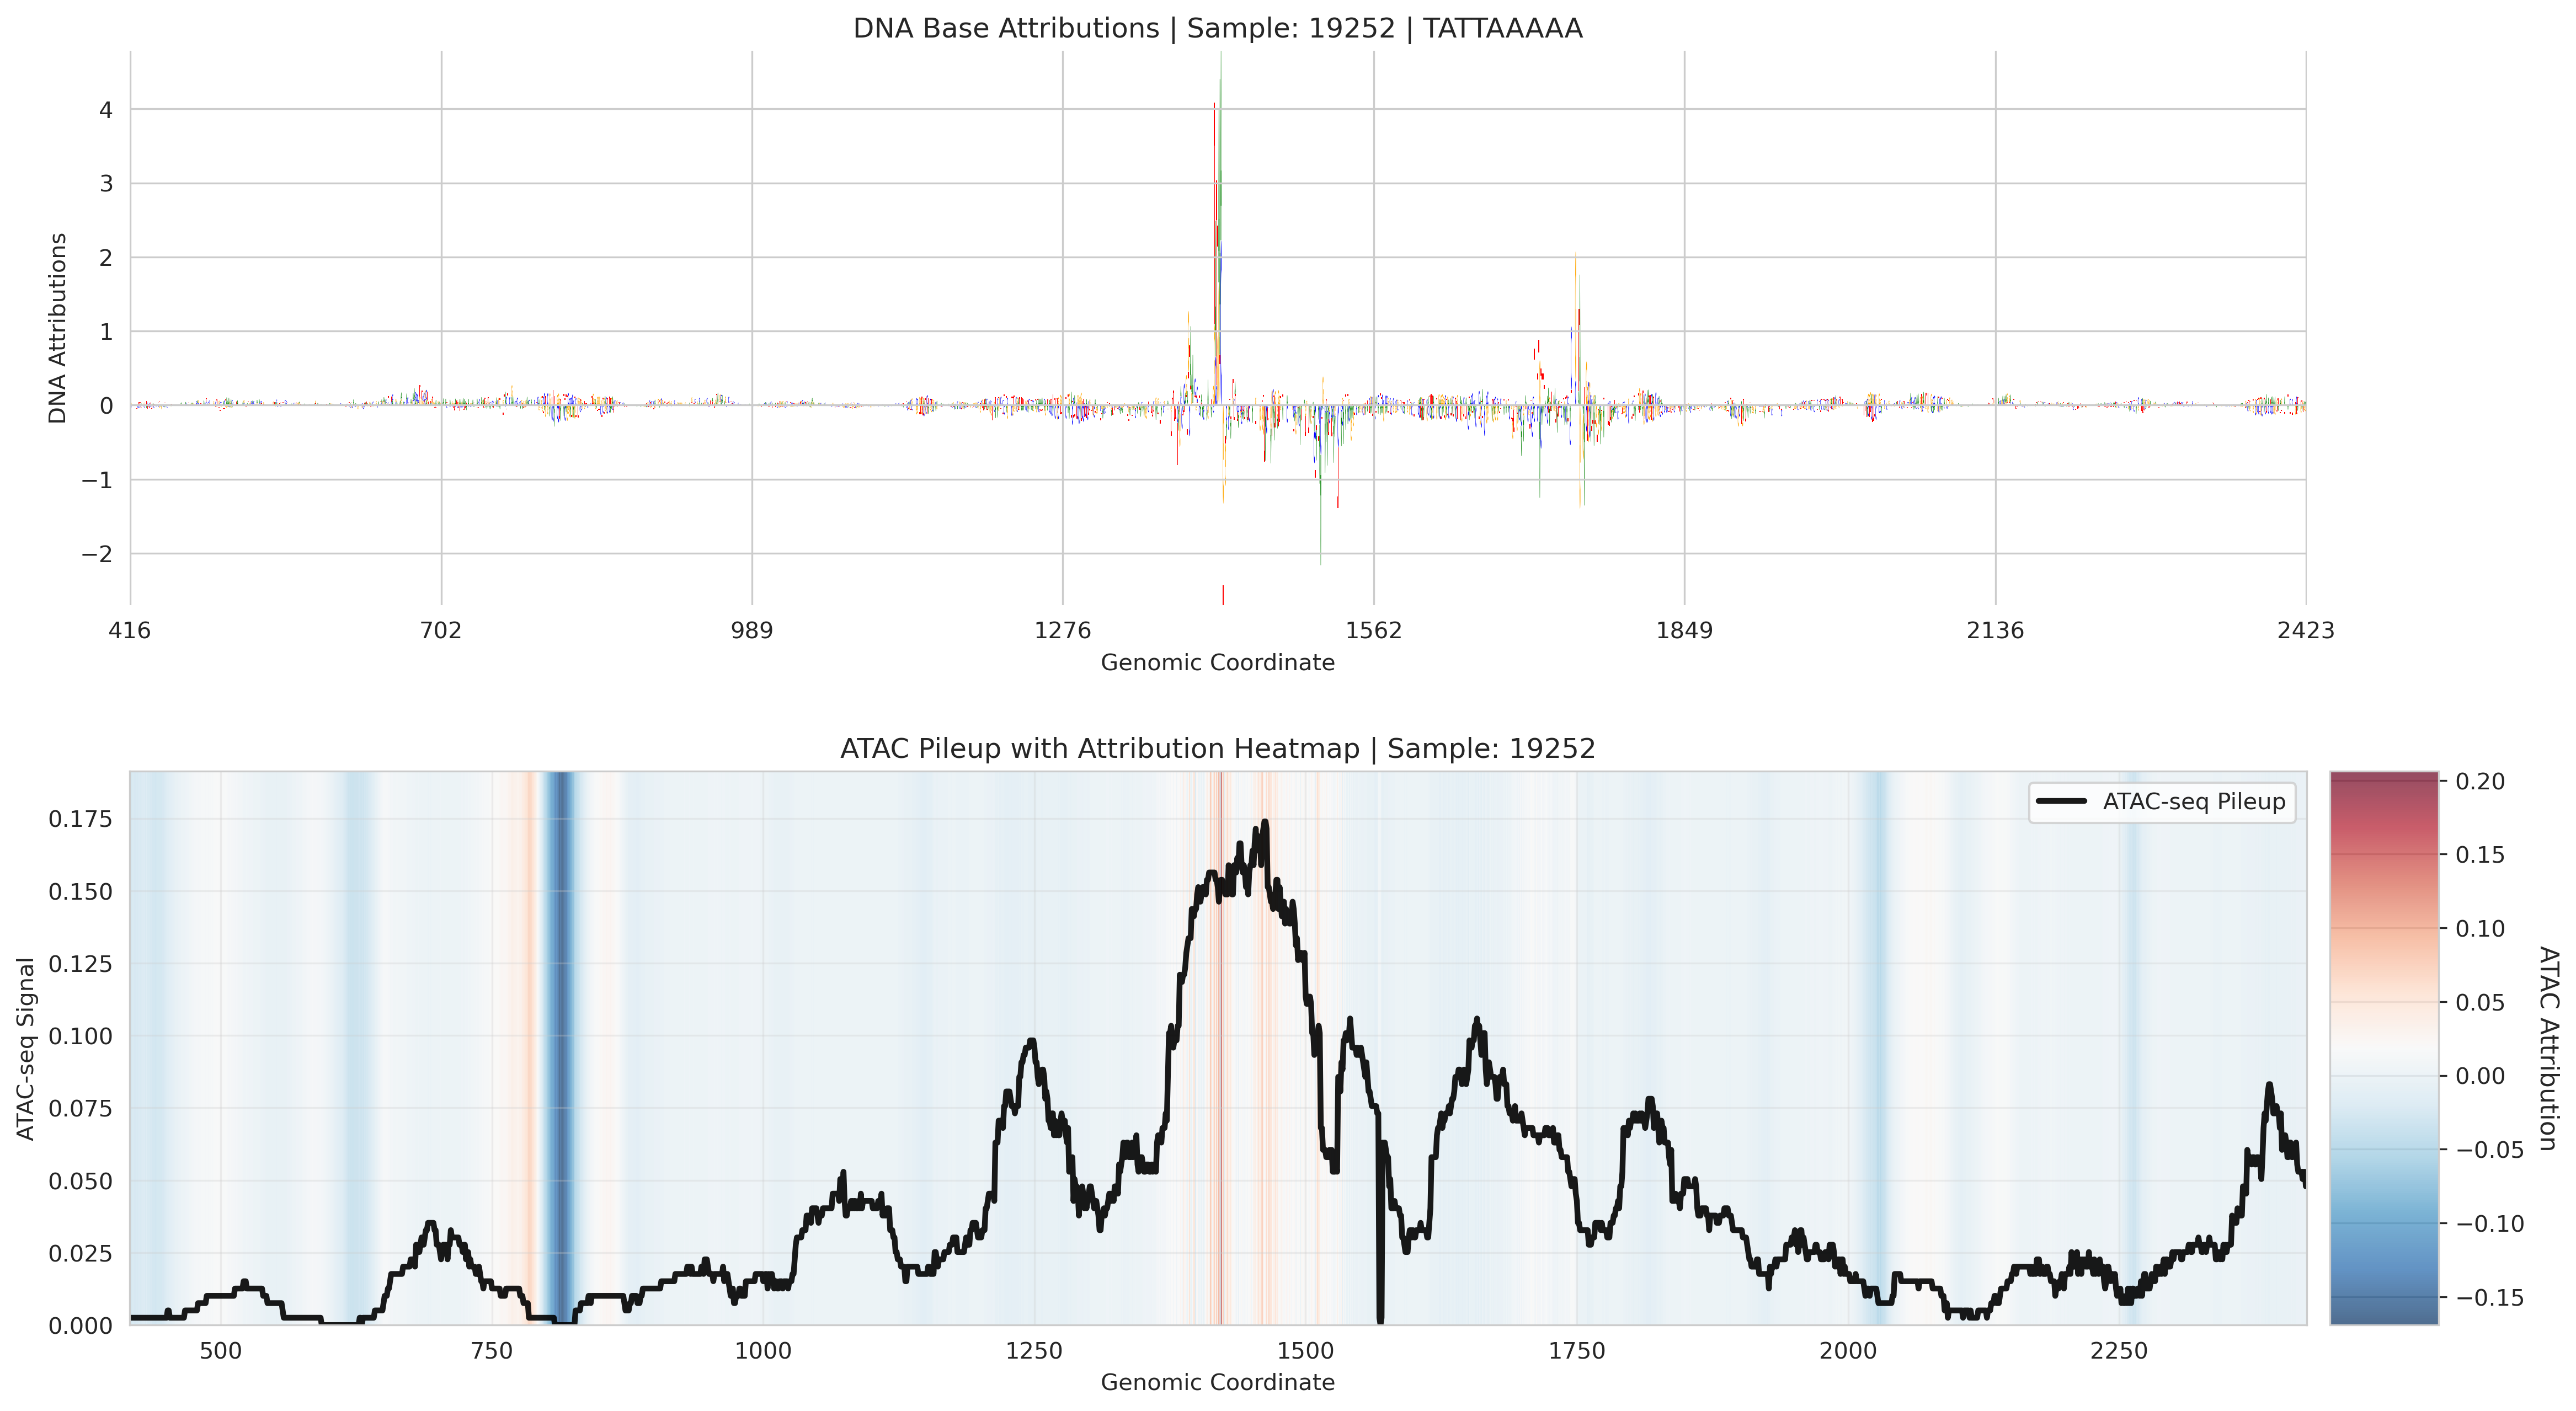

In [11]:
plot_seqlet_with_atac(seqlets, attrs_list,atac_attribution_list=atac_attribution_list, atac_pileup_list=atac_pileup_list, sample_rank=567, context_size=1000)


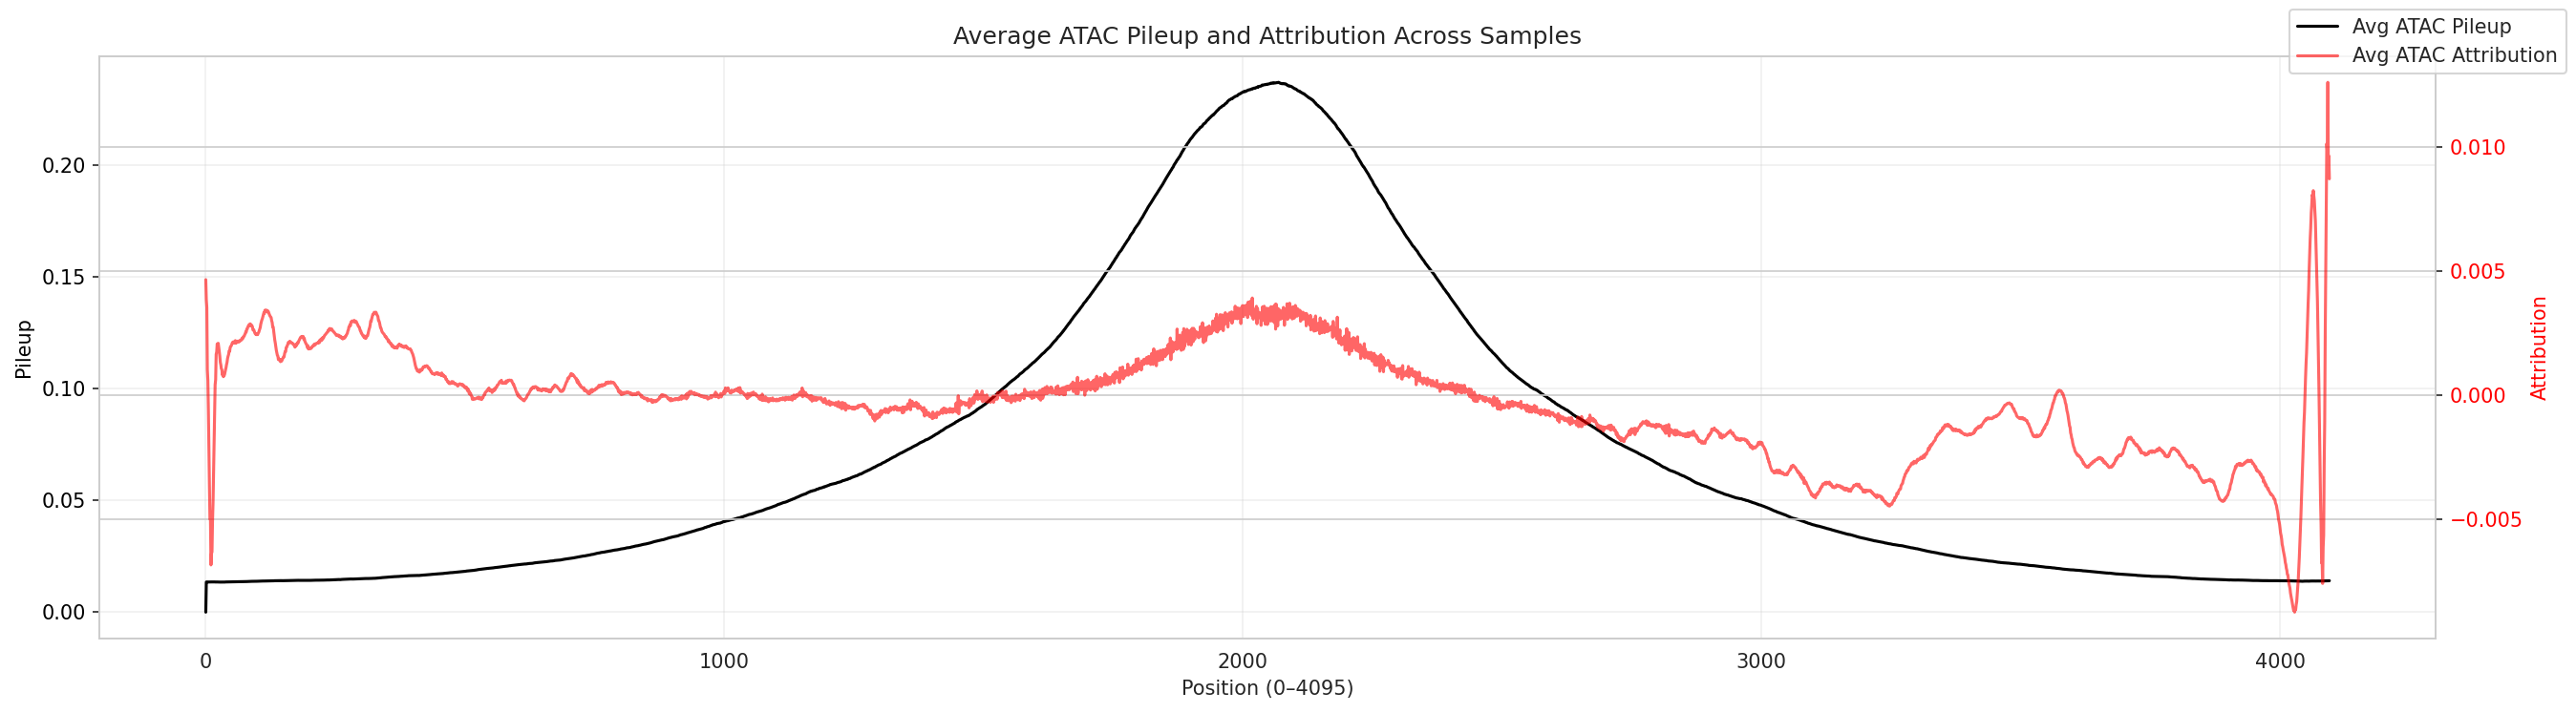

In [16]:

def plot_avg_atac_and_attribution(atac_pileup_list: np.ndarray, atac_attribution_list: np.ndarray):
    """
    Plot average ATAC pileup and attribution across all samples.
    Assumes both arrays are (n_samples, 4096).
    """
    mean_pileup = atac_pileup_list.mean(axis=0)
    mean_attr = atac_attribution_list.mean(axis=0)
    x = np.arange(len(mean_pileup))

    fig, ax1 = plt.subplots(figsize=(18, 5), dpi=150)

    ax1.plot(x, mean_pileup, color='black', label="Avg ATAC Pileup")
    ax1.set_ylabel("Pileup", color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    ax2.plot(x, mean_attr, color='red', alpha=0.6, label="Avg ATAC Attribution")
    ax2.set_ylabel("Attribution", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title("Average ATAC Pileup and Attribution Across Samples")
    ax1.set_xlabel("Position (0–4095)")
    ax1.grid(True, alpha=0.3)

    fig.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Call it:
plot_avg_atac_and_attribution(atac_pileup_list, atac_attribution_list)


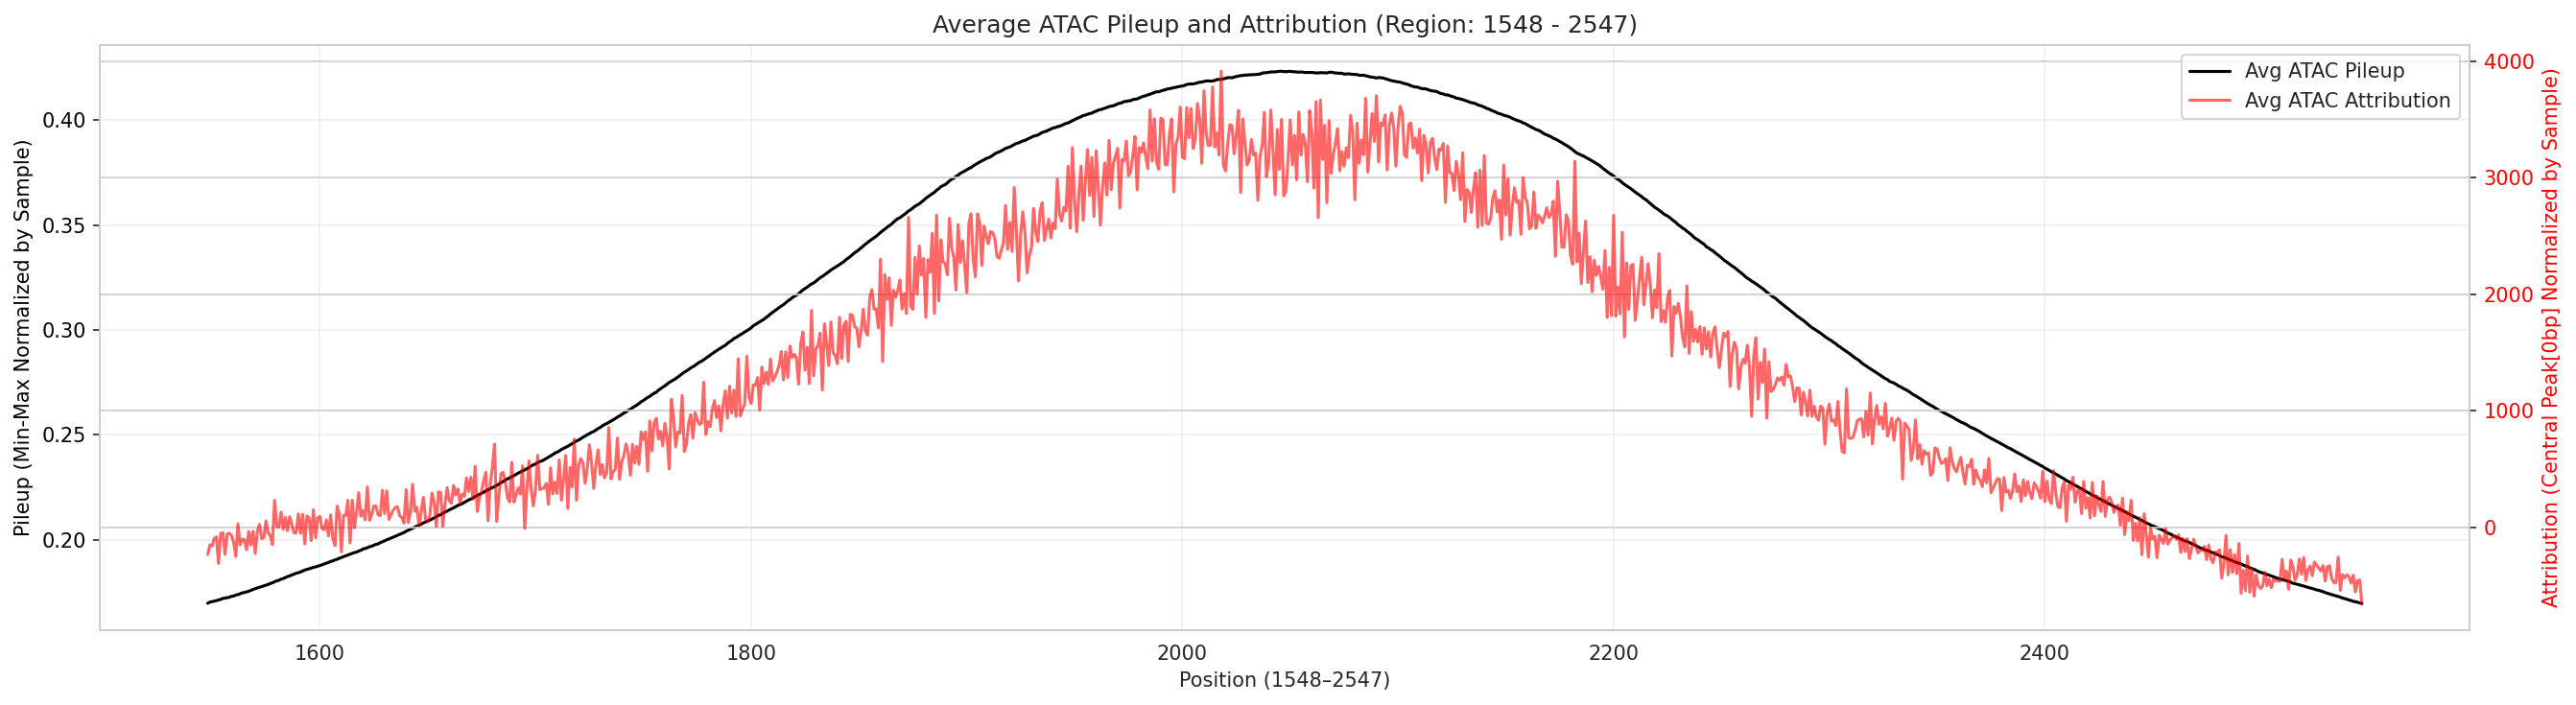

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your normalization functions are defined as before:
# normalize_rows_minmax, normalize_rows_by_peak, normalize_rows_by_central_peak

def normalize_rows_minmax(arr: np.ndarray) -> np.ndarray:
    """Normalize each row to range [0, 1]."""
    min_vals = arr.min(axis=1, keepdims=True)
    max_vals = arr.max(axis=1, keepdims=True)
    denom = np.clip(max_vals - min_vals, a_min=1e-6, a_max=None)
    return (arr - min_vals) / denom

def normalize_rows_by_peak(arr: np.ndarray) -> np.ndarray:
    """Normalize each row by its maximum value."""
    max_vals = arr.max(axis=1, keepdims=True)
    denom = np.clip(max_vals, a_min=1e-6, a_max=None)
    return arr / denom

def normalize_rows_by_central_peak(arr: np.ndarray, window_size: int = 100) -> np.ndarray:
    """Normalize each row by the maximum value in its central region."""
    center = arr.shape[1] // 2
    half_window = window_size // 2
    # Ensure central_region slicing is robust
    start_slice = max(0, center - half_window)
    end_slice = min(arr.shape[1], center + half_window + (window_size % 2)) # ensure full window size
    central_region = arr[:, start_slice:end_slice]
    
    if central_region.shape[1] == 0: # Handle case where central window is empty (e.g. arr is too small)
        peak_vals = np.ones((arr.shape[0], 1)) * 1e-6 # Avoid division by zero, effectively no scaling
    else:
        peak_vals = central_region.max(axis=1, keepdims=True)
        
    denom = np.clip(peak_vals, a_min=1e-6, a_max=None)
    return arr / denom


def plot_avg_atac_and_attribution(atac_pileup_list: np.ndarray,
                                  atac_attribution_list: np.ndarray,
                                  normalize_pileup_method: str = "minmax",
                                  normalize_attribution_method: str = "peak",
                                  context_size: int = None, # New parameter for zooming
                                  central_peak_norm_window_size: int = 100 # Pass through for central peak norm
                                  ):
    """
    Plot average ATAC pileup and attribution across all samples.
    Normalization methods can be specified.
    Allows zooming to a central context window.
    """
    processed_pileup = atac_pileup_list.copy()
    pileup_norm_label = " (Raw)"
    if normalize_pileup_method == "minmax":
        processed_pileup = normalize_rows_minmax(processed_pileup)
        pileup_norm_label = " (Min-Max Normalized by Sample)"
    elif normalize_pileup_method == "peak":
        processed_pileup = normalize_rows_by_peak(processed_pileup)
        pileup_norm_label = " (Peak Normalized by Sample)"
    elif normalize_pileup_method == "central_peak":
        processed_pileup = normalize_rows_by_central_peak(processed_pileup, window_size=central_peak_norm_window_size)
        pileup_norm_label = " (Central Peak Normalized by Sample)"
    elif normalize_pileup_method != "none":
        raise ValueError(f"Unknown normalize_pileup_method: {normalize_pileup_method}")

    processed_attribution = atac_attribution_list.copy()
    attr_norm_label = " (Raw)"
    if normalize_attribution_method == "minmax":
        processed_attribution = normalize_rows_minmax(processed_attribution)
        attr_norm_label = " (Min-Max Normalized by Sample)"
    elif normalize_attribution_method == "peak":
        processed_attribution = normalize_rows_by_peak(processed_attribution)
        attr_norm_label = " (Peak Normalized by Sample)"
    elif normalize_attribution_method == "central_peak":
        processed_attribution = normalize_rows_by_central_peak(processed_attribution, window_size=central_peak_norm_window_size)
        attr_norm_label = f" (Central Peak[{central_peak_norm_window_size}bp] Normalized by Sample)"
    elif normalize_attribution_method != "none":
        raise ValueError(f"Unknown normalize_attribution_method: {normalize_attribution_method}")

    mean_pileup = processed_pileup.mean(axis=0)
    mean_attr = processed_attribution.mean(axis=0)
    
    full_length = len(mean_pileup)
    x_coords = np.arange(full_length)

    # Determine window for plotting
    if context_size is not None and 0 < context_size < full_length:
        center_idx = full_length // 2
        half_cs = context_size // 2
        
        win_start = max(0, center_idx - half_cs)
        win_end = min(full_length, win_start + context_size)
        
        # Adjust start if win_end hit full_length, to try to maintain context_size
        if win_end == full_length:
            win_start = max(0, full_length - context_size)

        mean_pileup_to_plot = mean_pileup[win_start:win_end]
        mean_attr_to_plot = mean_attr[win_start:win_end]
        x_to_plot = x_coords[win_start:win_end]
        plot_title_suffix = f" (Region: {win_start} - {win_end-1})"
    else:
        mean_pileup_to_plot = mean_pileup
        mean_attr_to_plot = mean_attr
        x_to_plot = x_coords
        plot_title_suffix = " (Full View)"

    if len(x_to_plot) == 0:
        print("Warning: Calculated plot window is empty. Plotting full range instead.")
        mean_pileup_to_plot = mean_pileup
        mean_attr_to_plot = mean_attr
        x_to_plot = x_coords
        plot_title_suffix = " (Full View - Empty Zoom Attempt)"


    fig, ax1 = plt.subplots(figsize=(18, 5), dpi=150)

    ax1.plot(x_to_plot, mean_pileup_to_plot, color='black', label="Avg ATAC Pileup")
    ax1.set_ylabel(f"Pileup{pileup_norm_label}", color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    ax2.plot(x_to_plot, mean_attr_to_plot, color='red', alpha=0.6, label="Avg ATAC Attribution")
    ax2.set_ylabel(f"Attribution{attr_norm_label}", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title("Average ATAC Pileup and Attribution" + plot_title_suffix)
    if len(x_to_plot) > 0:
        ax1.set_xlabel(f"Position ({x_to_plot[0]}–{x_to_plot[-1]})")
    else:
        ax1.set_xlabel("Position (Empty Range)")
        
    ax1.grid(True, alpha=0.3)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")

    plt.tight_layout()
    plt.show()


plot_avg_atac_and_attribution(
    atac_pileup_list, # Make sure this is defined from your data
    atac_attribution_list, # Make sure this is defined from your data
    normalize_pileup_method="minmax",
    normalize_attribution_method="central_peak",
    central_peak_norm_window_size=0,
    context_size=1000
)


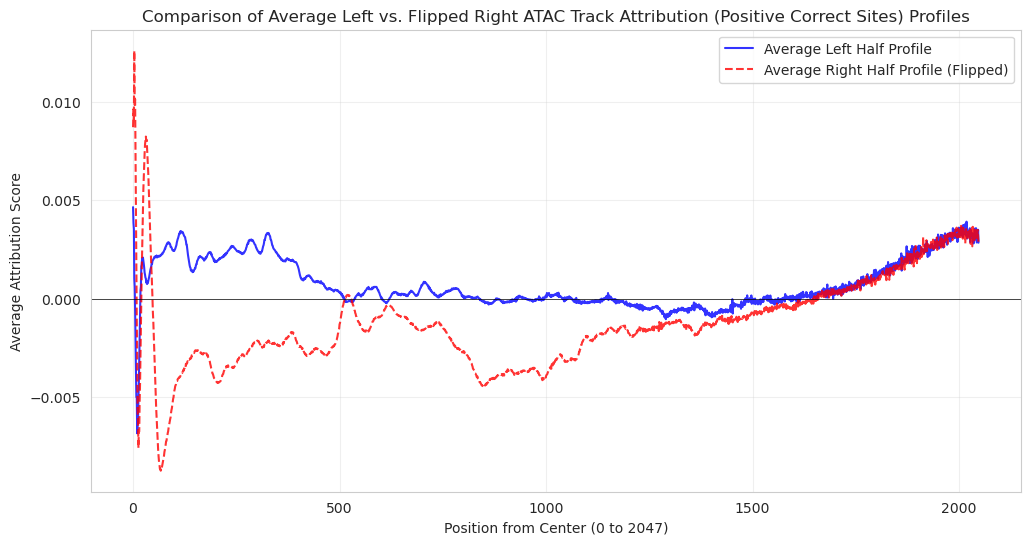

In [37]:
def plot_average_half_profiles(attribution_data: np.ndarray, data_label: str = "ATAC Track Attribution"):
    num_samples, L = attribution_data.shape
    mid_idx = L // 2

    left_half_data = attribution_data[:, :mid_idx]
    right_half_data = attribution_data[:, mid_idx:]

    avg_left_profile = np.mean(left_half_data, axis=0)
    # Flip the right half for comparison: last position of right half becomes first, etc.
    avg_right_profile_flipped = np.mean(right_half_data[:, ::-1], axis=0) 
    
    x_axis_half = np.arange(mid_idx)

    plt.figure(figsize=(12, 6))
    plt.plot(x_axis_half, avg_left_profile, label='Average Left Half Profile', color='blue', alpha=0.8)
    plt.plot(x_axis_half, avg_right_profile_flipped, label='Average Right Half Profile (Flipped)', color='red', linestyle='--', alpha=0.8)
    
    # Difference plot
    # plt.plot(x_axis_half, avg_left_profile - avg_right_profile_flipped, label='Difference (Left - Flipped Right)', color='green', alpha=0.5)

    plt.xlabel(f"Position from Center (0 to {mid_idx-1})")
    plt.ylabel("Average Attribution Score")
    plt.title(f"Comparison of Average Left vs. Flipped Right {data_label} Profiles")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.show()

# --- Example Usage ---
plot_average_half_profiles(atac_attribution_list, 
                           data_label="ATAC Track Attribution (Positive Correct Sites)")

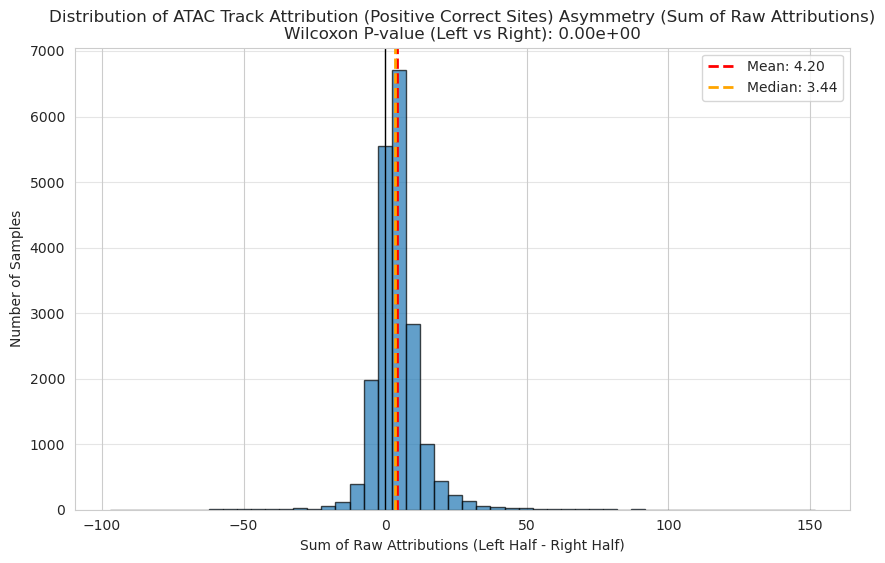

--- Asymmetry Analysis for ATAC Track Attribution (Positive Correct Sites) using Sum of Raw Attributions ---
Number of samples: 19786
Mean Asymmetry (Left - Right): 4.2019
Median Asymmetry (Left - Right): 3.4437
Standard Deviation of Asymmetry Scores: 9.3062
Wilcoxon signed-rank test statistic: 37282930.0000, P-value: 0
Result: Statistically significant evidence that the Left side has larger attribution.
--------------------------------------------------



(array([ 8.9549211 , 25.01852073, -0.31005233, ..., -5.34355464,
        -7.36744191, -4.23159011]),
 0.0)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assume 'atac_attribution_list' is your data (e.g., from df_positive_correct or df_balanced)
# It should have shape (number_of_samples, 4096)

def analyze_attribution_asymmetry(attribution_data: np.ndarray, 
                                  data_label: str = "ATAC Track Attribution",
                                  metric: str = 'sum_raw'):
    """
    Analyzes the asymmetry of attribution scores between the left and right halves of sequences.

    Args:
        attribution_data: Numpy array of shape (num_samples, sequence_length).
        data_label: String label for the data being analyzed (for plot titles).
        metric: The metric to use for quantifying attribution:
                'sum_raw': Sum of raw attribution scores.
                'sum_positive': Sum of positive attribution scores.
                'sum_absolute': Sum of absolute attribution scores.
    """
    num_samples, L = attribution_data.shape

    if L % 2 != 0:
        print(f"Warning: Sequence length {L} is odd. The exact center split might be slightly imbalanced.")
    
    # Define split point
    # For L=4096, mid_idx = 2048. Left: 0 to 2047. Right: 2048 to 4095.
    mid_idx = L // 2

    left_half_data = attribution_data[:, :mid_idx]
    right_half_data = attribution_data[:, mid_idx:]

    if metric == 'sum_raw':
        left_values = np.sum(left_half_data, axis=1)
        right_values = np.sum(right_half_data, axis=1)
        metric_label = "Sum of Raw Attributions"
    elif metric == 'sum_positive':
        left_values = np.sum(np.maximum(0, left_half_data), axis=1)
        right_values = np.sum(np.maximum(0, right_half_data), axis=1)
        metric_label = "Sum of Positive Attributions"
    elif metric == 'sum_absolute':
        left_values = np.sum(np.abs(left_half_data), axis=1)
        right_values = np.sum(np.abs(right_half_data), axis=1)
        metric_label = "Sum of Absolute Attributions"
    else:
        raise ValueError(f"Unknown metric: {metric}. Choose from 'sum_raw', 'sum_positive', 'sum_absolute'.")

    asymmetry_scores = left_values - right_values # Positive means left > right

    # --- Statistical Analysis ---
    mean_asymmetry = np.mean(asymmetry_scores)
    median_asymmetry = np.median(asymmetry_scores)
    # Paired t-test (to see if the mean difference is significantly different from 0)
    # Or Wilcoxon signed-rank test if normality is a concern (often more robust for scores)
    # t_stat, p_value = stats.ttest_rel(left_values, right_values)
    wilcoxon_stat, p_value = stats.wilcoxon(left_values, right_values, alternative='two-sided' if mean_asymmetry !=0 else 'greater') # H1: left != right
    
    # --- Plotting Histogram ---
    plt.figure(figsize=(10, 6))
    plt.hist(asymmetry_scores, bins=50, edgecolor='k', alpha=0.7)
    plt.axvline(mean_asymmetry, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_asymmetry:.2f}')
    plt.axvline(median_asymmetry, color='orange', linestyle='dashed', linewidth=2, label=f'Median: {median_asymmetry:.2f}')
    plt.axvline(0, color='black', linestyle='solid', linewidth=1)
    plt.xlabel(f"{metric_label} (Left Half - Right Half)")
    plt.ylabel("Number of Samples")
    plt.title(f"Distribution of {data_label} Asymmetry ({metric_label})\nWilcoxon P-value (Left vs Right): {p_value:.2e}")
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

    print(f"--- Asymmetry Analysis for {data_label} using {metric_label} ---")
    print(f"Number of samples: {num_samples}")
    print(f"Mean Asymmetry (Left - Right): {mean_asymmetry:.4f}")
    print(f"Median Asymmetry (Left - Right): {median_asymmetry:.4f}")
    print(f"Standard Deviation of Asymmetry Scores: {np.std(asymmetry_scores):.4f}")
    print(f"Wilcoxon signed-rank test statistic: {wilcoxon_stat:.4f}, P-value: {p_value:.4g}")

    if p_value < 0.05:
        if mean_asymmetry > 0:
            print("Result: Statistically significant evidence that the Left side has larger attribution.")
        elif mean_asymmetry < 0:
            print("Result: Statistically significant evidence that the Right side has larger attribution.")
        else:
            print("Result: Statistically significant, but mean difference is zero (might indicate symmetric deviations). Check median.")
    else:
        print("Result: No statistically significant difference found between left and right side attributions based on this metric.")
    print("--------------------------------------------------\n")
    return asymmetry_scores, p_value

# --- Example Usage ---
# Make sure 'atac_attribution_list' is loaded and available
# For example, if you processed 'df_positive_correct':
# _, _, atac_attribution_list_positive = process_region_data_fast(df_positive_correct) # Assuming this returns it

# If atac_attribution_list is already the numpy array from your previous code:
analyze_attribution_asymmetry(atac_attribution_list, 
                              data_label="ATAC Track Attribution (Positive Correct Sites)", 
                              metric='sum_raw')

# analyze_attribution_asymmetry(atac_attribution_list, 
#                               data_label="ATAC Track Attribution (Positive Correct Sites)", 
#                               metric='sum_positive')

# analyze_attribution_asymmetry(atac_attribution_list, 
#                               data_label="ATAC Track Attribution (Positive Correct Sites)", 
#                               metric='sum_absolute')

# You can also apply this to your DNA base attributions (attrs_list)
# Assuming attrs_list has shape (num_samples, 4, 4096)
# To analyze DNA base attributions, you might want to sum across the A,C,G,T dimension first
# or analyze each base channel separately if that's meaningful.
# For a general DNA importance, you could sum absolute values across bases, then sum across length:
# dna_importance_per_position = np.sum(np.abs(attrs_list), axis=1) # Shape: (num_samples, 4096)
# analyze_attribution_asymmetry(dna_importance_per_position, 
#                               data_label="Summed Absolute DNA Base Attribution (Positive Correct Sites)", 
#                               metric='sum_raw') # 'sum_raw' here means sum of summed_abs_dna_attr

Processing DNA base attributions (attrs_list)...

Analyzing asymmetry for Summed Absolute DNA Base Attributions:


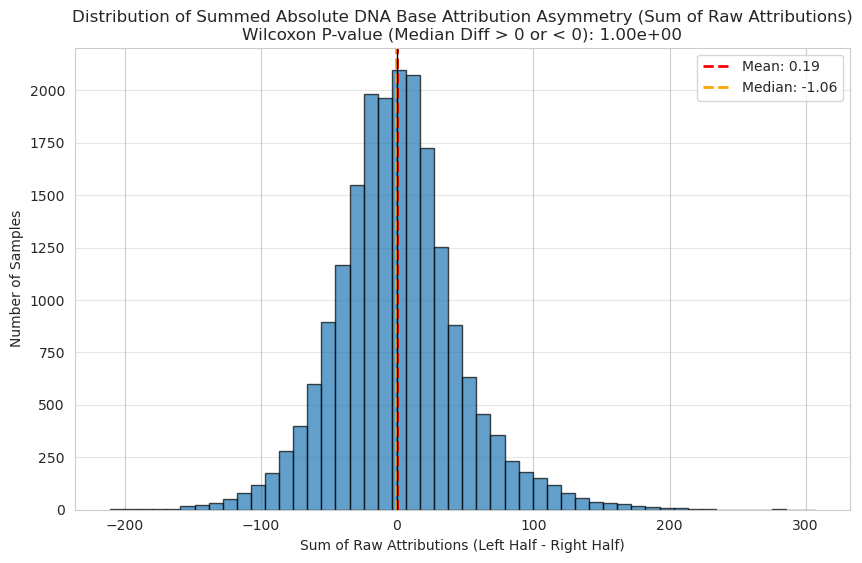

--- Asymmetry Analysis for Summed Absolute DNA Base Attribution using Sum of Raw Attributions ---
Number of samples: 19786
Mean Asymmetry (Left - Right): 0.1896
Median Asymmetry (Left - Right): -1.0629
Standard Deviation of Asymmetry Scores: 45.9776
Wilcoxon signed-rank test statistic: 95046341.0000, P-value: 0.9998
Result: No statistically significant difference found (or test not performed) between left and right side attributions based on this metric.
--------------------------------------------------



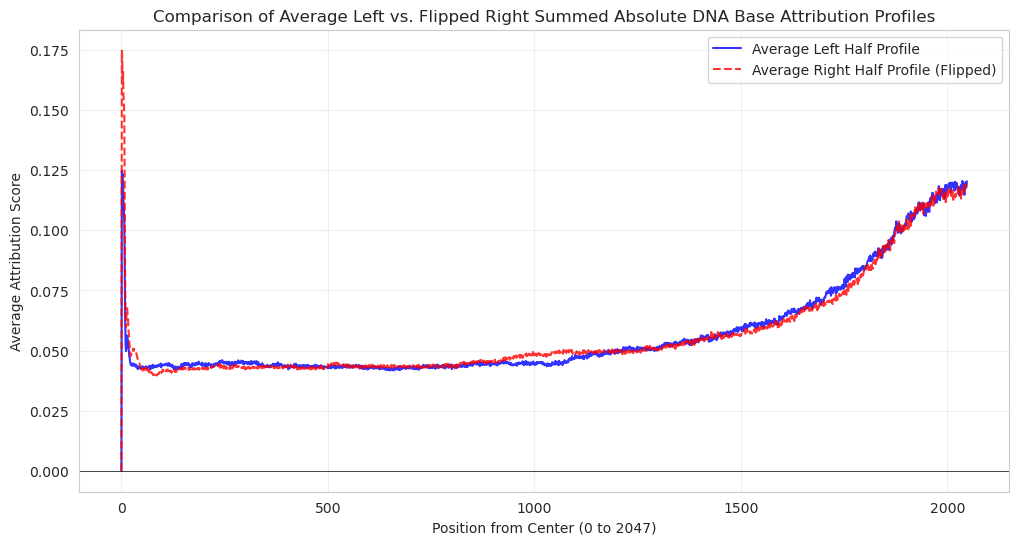

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats # Make sure scipy is imported for stats.wilcoxon

# Make sure your 'analyze_attribution_asymmetry' and 'plot_average_half_profiles'
# functions from the previous response are defined in your environment.
# (I'm re-pasting them here for completeness in this code block,
#  but you likely already have them)

def analyze_attribution_asymmetry(attribution_data: np.ndarray,
                                  data_label: str = "ATAC Track Attribution",
                                  metric: str = 'sum_raw'):
    """
    Analyzes the asymmetry of attribution scores between the left and right halves of sequences.
    (Same function as provided before)
    """
    num_samples, L = attribution_data.shape
    if L % 2 != 0:
        print(f"Warning: Sequence length {L} is odd. The exact center split might be slightly imbalanced.")
    mid_idx = L // 2
    left_half_data = attribution_data[:, :mid_idx]
    right_half_data = attribution_data[:, mid_idx:]

    if metric == 'sum_raw':
        left_values = np.sum(left_half_data, axis=1)
        right_values = np.sum(right_half_data, axis=1)
        metric_label = "Sum of Raw Attributions"
    elif metric == 'sum_positive':
        left_values = np.sum(np.maximum(0, left_half_data), axis=1)
        right_values = np.sum(np.maximum(0, right_half_data), axis=1)
        metric_label = "Sum of Positive Attributions"
    elif metric == 'sum_absolute':
        left_values = np.sum(np.abs(left_half_data), axis=1)
        right_values = np.sum(np.abs(right_half_data), axis=1)
        metric_label = "Sum of Absolute Attributions"
    else:
        raise ValueError(f"Unknown metric: {metric}. Choose from 'sum_raw', 'sum_positive', 'sum_absolute'.")

    asymmetry_scores = left_values - right_values
    mean_asymmetry = np.mean(asymmetry_scores)
    median_asymmetry = np.median(asymmetry_scores)
    # Use alternative='two-sided' for a general test of difference,
    # or specify 'greater' or 'less' if you have a directional hypothesis beforehand.
    # Given your previous finding, you might expect left > right, so alternative='greater' for left_values > right_values
    # (which means asymmetry_scores > 0).
    # For wilcoxon(x, y, alternative='greater'), it tests if median of x-y is greater than 0.
    # So, wilcoxon(asymmetry_scores, alternative='greater') if testing if median asymmetry > 0
    # or wilcoxon(left_values, right_values, alternative='greater')
    
    # Test if median of (left_values - right_values) is different from 0
    # If testing if left is specifically larger, H1 is median(left-right) > 0
    alt_hypothesis = 'two-sided'
    if np.abs(mean_asymmetry) > 1e-9 : # If there's a clear direction in the mean
        alt_hypothesis = 'greater' if mean_asymmetry > 0 else 'less'

    # For a paired test where we look at the differences:
    # We test if the median of these differences is non-zero.
    # If asymmetry_scores = left - right, we want to test if median(asymmetry_scores) is > 0 if we expect left > right
    if len(asymmetry_scores) > 0 and not np.all(asymmetry_scores == 0): # Wilcoxon needs non-identical samples or non-zero differences
        try:
            # We are testing the 'asymmetry_scores' directly. If we expect left > right, then asymmetry_scores > 0.
            # So, alternative='greater' tests if the median of asymmetry_scores is greater than 0.
            wilcoxon_stat, p_value = stats.wilcoxon(asymmetry_scores, alternative='greater' if mean_asymmetry > 0 else ('less' if mean_asymmetry < 0 else 'two-sided'))

        except ValueError as e: # Can happen if all differences are zero
            print(f"Wilcoxon test could not be performed: {e}")
            wilcoxon_stat, p_value = np.nan, np.nan
    else:
        wilcoxon_stat, p_value = np.nan, np.nan


    plt.figure(figsize=(10, 6))
    plt.hist(asymmetry_scores, bins=50, edgecolor='k', alpha=0.7)
    plt.axvline(mean_asymmetry, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_asymmetry:.2f}')
    plt.axvline(median_asymmetry, color='orange', linestyle='dashed', linewidth=2, label=f'Median: {median_asymmetry:.2f}')
    plt.axvline(0, color='black', linestyle='solid', linewidth=1)
    plt.xlabel(f"{metric_label} (Left Half - Right Half)")
    plt.ylabel("Number of Samples")
    plt.title(f"Distribution of {data_label} Asymmetry ({metric_label})\nWilcoxon P-value (Median Diff > 0 or < 0): {p_value:.2e}")
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.show()

    print(f"--- Asymmetry Analysis for {data_label} using {metric_label} ---")
    print(f"Number of samples: {num_samples}")
    print(f"Mean Asymmetry (Left - Right): {mean_asymmetry:.4f}")
    print(f"Median Asymmetry (Left - Right): {median_asymmetry:.4f}")
    print(f"Standard Deviation of Asymmetry Scores: {np.std(asymmetry_scores):.4f}")
    print(f"Wilcoxon signed-rank test statistic: {wilcoxon_stat:.4f}, P-value: {p_value:.4g}")

    if not np.isnan(p_value) and p_value < 0.05:
        if mean_asymmetry > 0: # And alternative was 'greater'
            print("Result: Statistically significant evidence that the Left side has larger attribution.")
        elif mean_asymmetry < 0: # And alternative was 'less'
             print("Result: Statistically significant evidence that the Right side has larger attribution.")
        else: # This case might occur if alternative was 'two-sided' and p < 0.05 but mean is near 0
             print("Result: Statistically significant difference detected, but mean is close to zero. Inspect median and distribution.")
    else:
        print("Result: No statistically significant difference found (or test not performed) between left and right side attributions based on this metric.")
    print("--------------------------------------------------\n")
    return asymmetry_scores, p_value


def plot_average_half_profiles(attribution_data: np.ndarray, data_label: str = "Generic Attribution"):
    """
    Plots the average profile of the left half vs. the average of the flipped right half.
    (Same function as provided before)
    """
    num_samples, L = attribution_data.shape
    mid_idx = L // 2
    left_half_data = attribution_data[:, :mid_idx]
    right_half_data = attribution_data[:, mid_idx:]
    avg_left_profile = np.mean(left_half_data, axis=0)
    avg_right_profile_flipped = np.mean(right_half_data[:, ::-1], axis=0)
    x_axis_half = np.arange(mid_idx)

    plt.figure(figsize=(12, 6))
    plt.plot(x_axis_half, avg_left_profile, label='Average Left Half Profile', color='blue', alpha=0.8)
    plt.plot(x_axis_half, avg_right_profile_flipped, label='Average Right Half Profile (Flipped)', color='red', linestyle='--', alpha=0.8)
    plt.xlabel(f"Position from Center (0 to {mid_idx-1})")
    plt.ylabel("Average Attribution Score")
    plt.title(f"Comparison of Average Left vs. Flipped Right {data_label} Profiles")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.show()


# --- Applying to DNA Base Attributions ---

# Assume 'attrs_list' is your DNA base attribution data, loaded as a NumPy array
# with shape (number_of_samples, 4, 4096).
# For example, this might come from your 'process_region_data_fast' function
# or directly from where you load your data.

# Example: if attrs_list is loaded:
# attrs_list, _, _ = process_region_data_fast(df_positive_correct) # Make sure this is correctly populated

if 'attrs_list' in locals() and isinstance(attrs_list, np.ndarray) and attrs_list.ndim == 3 and attrs_list.shape[1] == 4:
    print("Processing DNA base attributions (attrs_list)...")
    
    # 1. Preprocess attrs_list to get a per-position DNA importance score.
    # We sum the absolute values of attributions across the 4 bases (A,C,G,T) for each position.
    # This gives a single score per position representing total DNA nucleotide importance.
    # The resulting array will have non-negative values.
    dna_importance_scores_per_position = np.sum(np.abs(attrs_list), axis=1)
    # This array should have shape (number_of_samples, 4096)

    # 2. Analyze asymmetry for these DNA importance scores.
    # Since dna_importance_scores_per_position contains only non-negative values (it's a sum of absolute values),
    # using metric='sum_raw', 'sum_positive', or 'sum_absolute' on *these already processed scores*
    # will yield the same result for 'left_values' and 'right_values'.
    # 'sum_raw' is clear and sufficient here.
    print("\nAnalyzing asymmetry for Summed Absolute DNA Base Attributions:")
    dna_asymmetry_scores, dna_p_value = analyze_attribution_asymmetry(
        dna_importance_scores_per_position,
        data_label="Summed Absolute DNA Base Attribution",
        metric='sum_raw' 
    )

    # 3. Plot average half profiles for DNA importance
    plot_average_half_profiles(
        dna_importance_scores_per_position,
        data_label="Summed Absolute DNA Base Attribution"
    )

else:
    print("Warning: 'attrs_list' not found or not in the expected format (num_samples, 4, 4096). Skipping DNA base attribution asymmetry analysis.")

# For reference, how you might have called it for ATAC track attributions:
    print("\nAnalyzing asymmetry for ATAC Track Attributions (Sum of Raw):")
    analyze_attribution_asymmetry(
        atac_attribution_list,
        data_label="ATAC Track Attribution",
        metric='sum_raw'
    )

In [ ]:
# Nucleosome positioning: Asymmetric nucleosome arrangements around the FOXA1 binding site could lead to asymmetric accessibility features that the model deems important.
# Directional processes: Proximity to TSS and transcriptional direction, or enhancer activity that has a directional component.
# Higher-order chromatin structure: Looping or other interactions that create an asymmetric accessibility "signature" that the model picks up.